In [73]:
#Imports
#Dataprep
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import random

## Data Clean from HCP Data notebook

In [2]:
from ast import literal_eval
import re

In [195]:
data_file = 'Data/data_clean.csv.gz'

with gzip.open(data_file) as filepath:
    data = pd.read_csv(filepath, index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})

In [ ]:
def set_diagonal_to_one(matrix):
    np.fill_diagonal(matrix, 1)
    return matrix

In [414]:
def standardize_matrix(matrix):
    return (matrix - np.mean(matrix)) / np.std(matrix)

In [415]:
data['netmat'] = data['netmat'].apply(standardize_matrix)

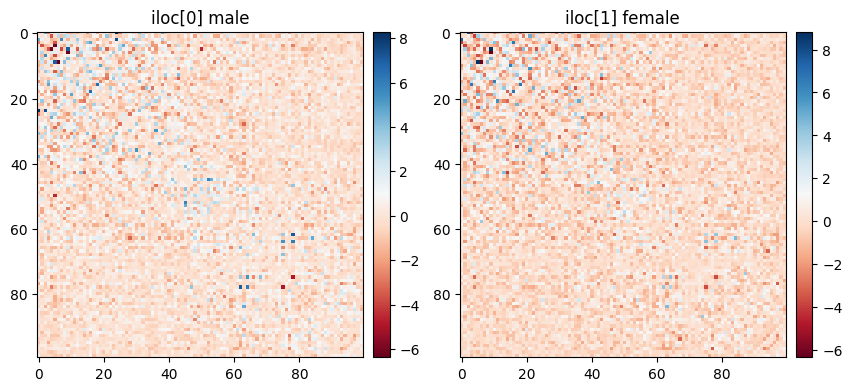

In [416]:
tsm = data.iloc[0].netmat
tsf = data.iloc[1].netmat
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10))
c = ax1.imshow(tsm, cmap='RdBu')
ax1.set_title('iloc[0] male')
fig.colorbar(c, ax=ax1, fraction=0.046, pad=0.03)
c = ax2.imshow(tsf, cmap='RdBu')
ax2.set_title('iloc[1] female')
fig.colorbar(c, ax=ax2, fraction=0.046, pad=0.03)

## Pytorch data preparing

In [351]:
def create_edge_index(num_nodes):
    num_edges = num_nodes * (num_nodes - 1) // 2
    source = []
    target = []
    for i in range(num_nodes):
        # iterate over all other nodes
        for j in range(i+1, num_nodes):
            source.append(i)
            target.append(j)

    edge_index = torch.tensor([source, target], dtype=torch.long)

    return edge_index

# Create an edge index for a fully connected graph with 100 nodes
edges = create_edge_index(100)
edges.size()

torch.Size([2, 4950])

In [352]:
import torch_geometric.utils as utils

In [417]:
netmats = data['netmat']

In [418]:
example = netmats.iloc[5]
mask = np.triu(abs(example) > 1, k=1)
edge_i = np.transpose(np.nonzero(mask))
t = torch.tensor(edge_i.T)
t.size()

torch.Size([2, 1062])

In [419]:
#Create an undirected edge index from a partial correlation matrix
def edge_gen_treshold(netmat, treshold):
    mask = np.triu(abs(netmat) > treshold, k=0) # using only bottom triangle 
    edge_i = np.transpose(np.nonzero(mask))
    return torch.tensor(edge_i.T)

In [428]:
ex_edges = edge_gen_treshold(example, 1)

In [429]:
torch.tensor(ex_edges).size()

C:\Users\terho\AppData\Local\Temp\ipykernel_22656\575367257.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ex_edges).size()


torch.Size([2, 1062])

In [431]:
tsf

array([[-0.03389855, -0.1640474 ,  7.56382156, ..., -0.41528506,
        -0.37111237,  0.230712  ],
       [-0.1640474 , -0.03389855,  1.191117  , ..., -0.37585957,
         0.32845965, -0.36834829],
       [ 7.56382156,  1.191117  , -0.03389855, ...,  0.8082256 ,
         0.155643  ,  0.16535678],
       ...,
       [-0.41528506, -0.37585957,  0.8082256 , ..., -0.03389855,
         0.57555996,  1.32436338],
       [-0.37111237,  0.32845965,  0.155643  , ...,  0.57555996,
        -0.03389855,  0.5329141 ],
       [ 0.230712  , -0.36834829,  0.16535678, ...,  1.32436338,
         0.5329141 , -0.03389855]])

In [432]:
import networkx as nx

C:\Users\terho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\storage.py:449: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


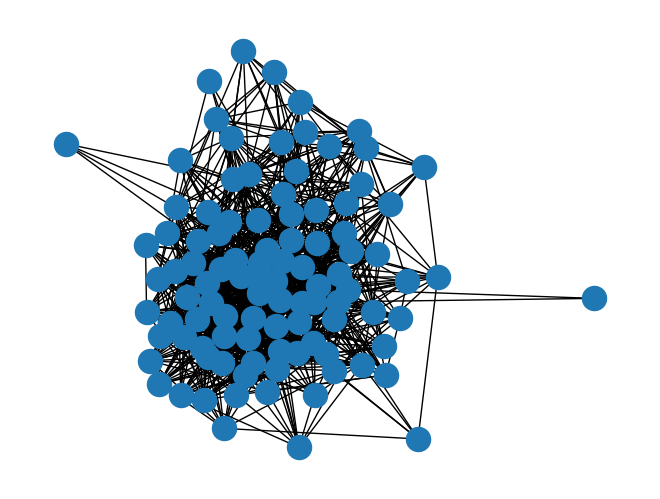

In [433]:
d = Data(x=None, edge_index=ex_edges)
g = torch_geometric.utils.to_networkx(d, to_undirected=True)
nx.draw(g)

In [434]:
data['Gender'] = data['Gender'].replace({"M":0, "F":1})

In [435]:
data['Gender']

subject_id
100206    0
100307    1
100408    0
100610    0
101006    1
         ..
992673    1
992774    0
993675    1
994273    0
996782    1
Name: Gender, Length: 1003, dtype: int64

In [436]:
labels = torch.tensor(data['Gender'].values)
labels

tensor([0, 1, 0,  ..., 1, 0, 1])

In [440]:
netmats = data['netmat']

def collate(data_list):
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }

# Custom dataset class
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1)):
        self.netmats = netmats
        self.labels = labels
        self.edges = edges # premade edge_index
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot)
        val_samples = int(split_ratio[1] * tot)
        
        #suffle
        indices = list(range(tot))
        random.shuffle(indices)
        
        #splits
        self.train_indices = indices[:train_samples]  # 0 - train_samples
        self.val_indices = indices[train_samples:train_samples + val_samples]
        self.test_indices = indices[train_samples + val_samples:]
        
    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = torch.tensor(self.netmats.iloc[idx]).float()
        edge_index = edge_gen_treshold(nmap, 1) #Change treshold here (two is great for testing)
        graph_data = Data(x=nmap, edge_index=edge_index)
        label = self.labels[idx]
        return graph_data, label
    
    def get_split(self, idx):
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

# Create the custom dataset
edges = None # No preset
collate_fn = collate
dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)

In [441]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 1082])], 'label': [tensor(1)]}


In [515]:
class GCN(nn.Module):
    def __init__(self, hidden_d):
        super(GCN, self).__init__()
        self.fbn = nn.BatchNorm1d(100,100)
        self.conv1 = GCNConv(100, hidden_d)
        self.bn1 = nn.BatchNorm1d(hidden_d, hidden_d)
        self.conv2 = GCNConv(hidden_d, hidden_d)
        #self.bn2 = nn.BatchNorm1d(hidden_d)
        self.classifier = Linear(hidden_d, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        #x = self.fbn(x)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.5)(x)
        x = self.conv2(x, edge_index)
        #x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.5)(x)
        x = self.classifier(x).mean(dim=0)
        return x
    

In [516]:
hidden_dimmension = 30
model = GCN(hidden_dimmension)
print(model)

GCN(
  (fbn): BatchNorm1d(100, eps=100, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(100, 30)
  (bn1): BatchNorm1d(30, eps=30, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(30, 30)
  (classifier): Linear(in_features=30, out_features=1, bias=True)
)


In [517]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 1038])], 'label': [tensor(1)]}


In [518]:
ah = model(next(test))

In [519]:
ah

tensor([-0.0049], grad_fn=<MeanBackward1>)

In [520]:

criterion = nn.BCEWithLogitsLoss()
print(ah.double(), torch.tensor(1).double())
criterion(ah.double(),torch.tensor(1).double())

tensor([-0.0049], dtype=torch.float64, grad_fn=<ToCopyBackward0>) tensor(1., dtype=torch.float64)


ValueError: Target size (torch.Size([])) must be the same as input size (torch.Size([1]))

In [521]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (out.double() > 0.5).float()
        if pred == label.float():
            num_true += 1
        if pred == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device, loss_fn):
    model.eval()
    cor = 0
    tot = 0
    total_loss = 0
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.float() > 0.5).float()
        y = d['label'][0]
        cor += (pred == y).sum()
        tot += 1
        total_loss += loss_fn(out.squeeze().float(), y.float())
    return cor/tot, total_loss

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_m(model, loader, device):
    model.eval()
    predictions = []
    labels = []
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.float() > 0.5).float()
            predictions.append(pred.numpy())
            labels.append(d['label'][0].numpy())
    predictions = predictions
    labels = labels
    cm = confusion_matrix(labels, predictions)
    cm_norm = cm/len(loader)
    c_names = ['True Neg','False Pos','False Neg','True Pos']
    c_counts = cm.flatten()
    c_percentages = ["{0:.2%}".format(value) for value in cm_norm.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(c_names,c_counts,c_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    s = sn.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues')
    s.set(xlabel="Predicted", ylabel="True")
    plt.show()
        
    
        

Epoch: 1/15, Loss: 549.269, Avg Loss: 0.685, Train: 68.70%, Validation: 56.00%, Val Loss: 67.557, Train Eval Loss: 477.472
Epoch: 2/15, Loss: 491.070, Avg Loss: 0.612, Train: 74.81%, Validation: 65.00%, Val Loss: 68.455, Train Eval Loss: 399.486
Epoch: 3/15, Loss: 451.827, Avg Loss: 0.563, Train: 77.06%, Validation: 69.00%, Val Loss: 73.940, Train Eval Loss: 397.059
Epoch: 4/15, Loss: 436.781, Avg Loss: 0.545, Train: 79.05%, Validation: 70.00%, Val Loss: 81.193, Train Eval Loss: 386.144
Epoch: 5/15, Loss: 404.340, Avg Loss: 0.504, Train: 78.05%, Validation: 71.00%, Val Loss: 83.061, Train Eval Loss: 392.603
Epoch: 6/15, Loss: 387.020, Avg Loss: 0.483, Train: 79.05%, Validation: 64.00%, Val Loss: 105.753, Train Eval Loss: 452.256
Epoch: 7/15, Loss: 376.755, Avg Loss: 0.470, Train: 75.31%, Validation: 64.00%, Val Loss: 107.491, Train Eval Loss: 492.418
Epoch: 8/15, Loss: 350.575, Avg Loss: 0.437, Train: 82.42%, Validation: 71.00%, Val Loss: 94.336, Train Eval Loss: 376.973
Epoch: 9/15, L

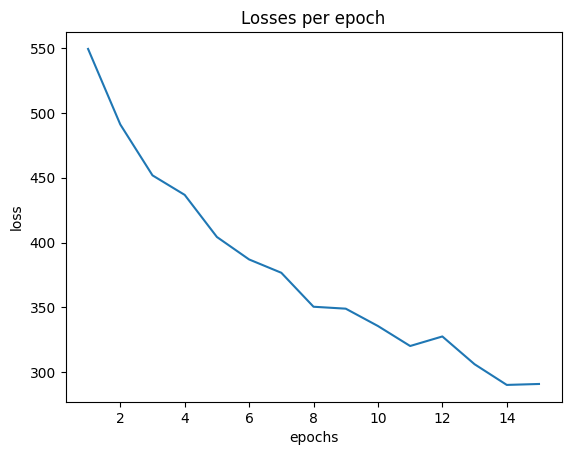

In [522]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dimmension = 25
model = GCN(hidden_dimmension).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.005, weight_decay=0.0000005) #, weight_decay=0.0000005
criterion = nn.BCEWithLogitsLoss()
losses = []
avg_losses = []
avg_val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
    train_results, train_loss = eval(model, train_loader, device, criterion)
    val_results, val_loss = eval(model, val_loader, device, criterion)
    losses.append(loss)
    avg_loss = loss / len(train_loader)
    avg_losses.append(avg_loss)
    avg_val_loss = val_loss/len(val_loader)
    avg_val_losses.append(avg_val_loss)
    print(f'Epoch: {epoch + 1}/{num_epochs}, '
          f'Loss: {loss:.3f}, '
          f'Avg Loss: {avg_loss:.3f}, '
          f'Train: {100 * train_results:.2f}%, '
          f'Validation: {100 * val_results:.2f}%, '
          f'Val Loss: {val_loss:.3f}, '
          f'Train Eval Loss: {train_loss:.3f}')
           
e = np.arange(1,num_epochs+1)
fig, ax = plt.subplots()
ax.plot(e,losses)
ax.set(xlabel='epochs', ylabel='loss', title='Losses per epoch')
plt.show()

Validation Confusion Table


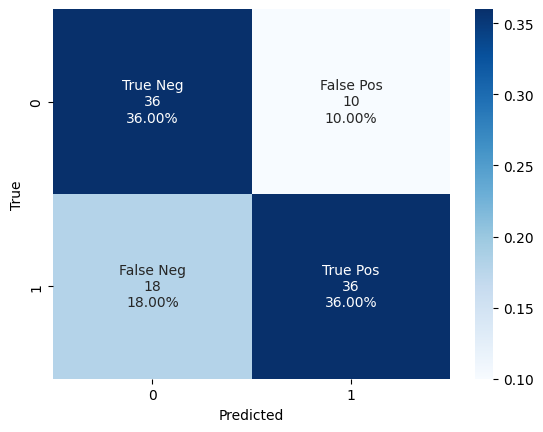

In [524]:
print("Validation Confusion Table")
conf_m(model, val_loader, device)

Training Confusion Table


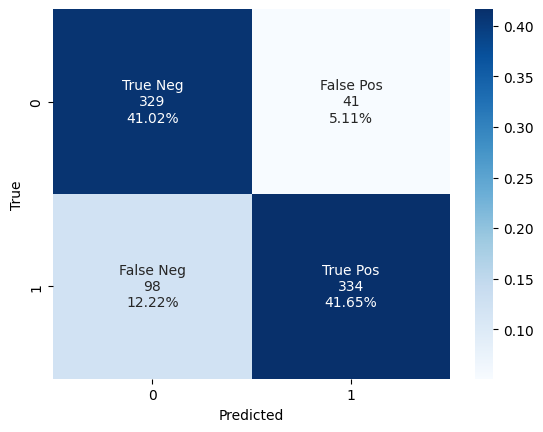

In [525]:
print("Training Confusion Table")
conf_m(model,train_loader,device)

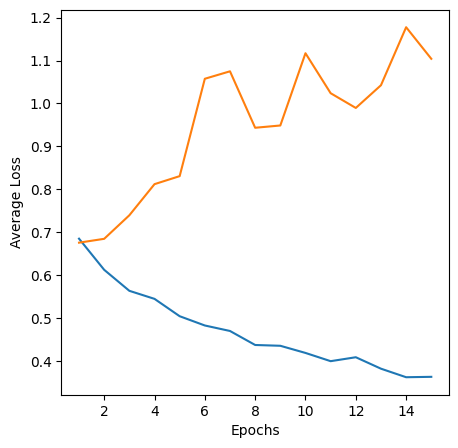

In [526]:
e = np.arange(1,num_epochs+1)
fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(e,avg_losses)
ax.plot(e,avg_val_losses)
ax.set(xlabel='Epochs', ylabel='Average Loss')
plt.show()

In [527]:
test_a, test_l = eval(model, test_loader, device, criterion)
print(f"Test Accuracy: {100 * test_a:.4f}%, Test Loss: {test_l:.3f}")

Test Accuracy: 71.2871%, Test Loss: 83.707


In [528]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tens

In [529]:
i = 0
for parameter in model.parameters():
    if i == 7:
        matrix = parameter.data.numpy()
    i += 1

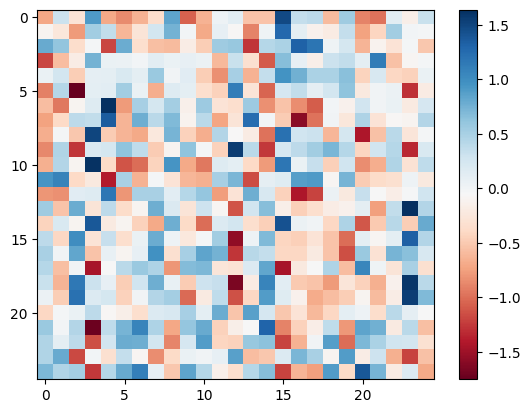

In [530]:
plt.imshow(matrix, aspect='auto', cmap='RdBu')
plt.colorbar()